In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/examples/tuning/getting_started_tuning.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/tuning/getting_started_tuning.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/tuning/getting_started_tuning.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Tuning and deploy a foundation model

Creating an LLM requires massive amounts of data, significant computing resources, and specialized skills. On Vertex AI, tuning allows you to customize a foundation model for more specific tasks or knowledge domains.

While the prompt design is excellent for quick experimentation, if training data is available, you can achieve higher quality by tuning the model. Tuning a model enables you to customize the model response based on examples of the task you want the model to perform.

For more details on tuning have a look at the [official documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models). 

### Objective

This tutorial teaches you how to tune a foundational model on new unseen data and you will use the following Google Cloud products:

- Vertex AI Generative AI Studio
- Vertex AI Pipelines
- Vertex AI Model Registry
- Vertex AI Endpoints

The steps performed include:

- Get training data from BQ and generate a JSONL file 
- Upload training data 
- Create a pipeline job
- Inspect your model on Vertex AI Model Registry
- Get predictions from your tuned model

### Quota
**important**: Tuning the text-bison@001  model uses the tpu-v3-8 training resources and the accompanying quotas from your Google Cloud project. Each project has a default quota of eight v3-8 cores, which allows for one to two concurrent tuning jobs. If you want to run more concurrent jobs you need to request additional quota via the [Quotas page](https://console.cloud.google.com/iam-admin/quotas).

### Costs
This tutorial uses billable components of Google Cloud:

* Vertex AI Generative AI Studio

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Install Vertex AI SDK

In [ ]:
!pip install google-cloud-aiplatform google-cloud-bigquery --upgrade --user

**Colab only:** Uncomment the following cell to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top. 

In [ ]:
# # Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

### BigQuery IAM
Now you need to add permissions to the service account:
- Go to the [IAM page](https://console.cloud.google.com/iam-admin/) in the console
- Look for the default compute service account. It should look something like this: `<project-number>-compute@developer.gserviceaccount.com`
- Assign the default compute service account with `bigquery.user` 

### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`. Otherwise, check the support page: [Locate the [project ID](https://support.google.com/googleapi/answer/7014113))

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

### Create a bucket
Now you have to create a bucket that we will use to store our tuning data. To avoid name collisions between users on resources created, you generate a UUID for each instance session and append it to the name of the resources you create in this tutorial.

In [ ]:
import random
import string


# Generate a uuid of a specified length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

Choose a bucket name and update the `BUCKET_NAME` parameter. 

In [ ]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION = "us-central1"  # @param {type: "string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = "vertex-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

### Import libraries

In [ ]:
from typing import Union

import pandas as pd
from google.cloud import aiplatform, bigquery
from vertexai.preview.language_models import TextGenerationModel

## Tune your Model

Now it's time for you to create a tuning job. Tune a foundation model by creating a pipeline job using Generative AI Studio, cURL, or the Python SDK. In this notebook, we will be using the Python SDK. You will be using a Q&A with a context dataset in JSON format. 

### Training Data
💾 Your model tuning dataset must be in a JSONL format where each line contains a single training example. You must make sure that you include instructions. 

You will use the StackOverflow data on BigQuery Public Datasets, limiting to questions with the `python` tag, and accepted answers for answers since 2020-01-01.

First create a helper function to let you easily query BigQuery and return the results as a Pandas DataFrame.

In [ ]:
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Run a BigQuery query and return the job ID or result as a DataFrame
    Args:
        sql: SQL query, as a string, to execute in BigQuery
    Returns:
        df: DataFrame of results from query,  or error, if any
    """

    bq_client = bigquery.Client()

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

Next define the query. 

In [ ]:
df = run_bq_query(
    """
SELECT
    CONCAT(q.title, q.body) as input_text,
    a.body AS output_text
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a
ON
    q.accepted_answer_id = a.id
WHERE 
    q.accepted_answer_id IS NOT NULL AND 
    REGEXP_CONTAINS(q.tags, "python") AND
    a.creation_date >= "2020-01-01"
LIMIT 
    50000
"""
)

df.head()

There should be 50k questions and answers.

In [ ]:
print(len(df))

For tuning, the training data first needs to be converted into a JSONL format.

In [ ]:
df_jsonl = df.to_json(orient="records", lines=True)

print(f"Length: {len(df_jsonl)}")

print(df_jsonl[0:100])

Next, you can write it to a local JSONL before transferring it to Google Cloud Storage (GCS).

In [ ]:
training_data_filename = "training_data_stack_overflow_python_qa.jsonl"

with open(training_data_filename, "w") as f:
    f.write(df_jsonl)

You can then export the local file to GCS, so that it can be used by Vertex AI for the tuning job.

In [ ]:
! gsutil cp $training_data_filename $BUCKET_URI

You can check to make sure that the file successfully transferred to your Google Cloud Storage bucket:

In [ ]:
! gsutil ls -al $BUCKET_URI

In [ ]:
TRAINING_DATA_URI = f"{BUCKET_URI}/{training_data_filename}"  # TOUPDATE

### Model Tuning
Now it's time to start to tune a model. You will use the Vertex AI SDK to submit our tuning job. 

#### Recommended Tuning Configurations
✅ Here are some recommended configurations for tuning a foundation model based on the task, in this example Q&A. You can find more in the [documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models).

Extractive QA:
- Make sure that your train dataset size is 100+ 
- Training steps [100-500]. You can try more than one value to get the best performance on a particular dataset (e.g. 100, 200, 500)

In [ ]:
MODEL_NAME = f"genai-workshop-tuned-model-{UUID}"

In [ ]:
def tuned_model(
    project_id: str,
    location: str,
    training_data: str,
    model_display_name: str,
    train_steps=100,
):

    """Prompt-tune a new model, based on a prompt-response data.

    "training_data" can be either the GCS URI of a file formatted in JSONL format
    (for example: training_data=f'gs://{bucket}/{filename}.jsonl'), or a pandas
    DataFrame. Each training example should be JSONL record with two keys, for
    example:
      {
        "input_text": <input prompt>,
        "output_text": <associated output>
      },
    or the pandas DataFame should contain two columns:
      ['input_text', 'output_text']
    with rows for each training example.

    Args:
      project_id: GCP Project ID, used to initialize aiplatform
      location: GCP Region, used to initialize aiplatform
      training_data: GCS URI of training file or pandas dataframe of training data
      train_steps: Number of training steps to use when tuning the model.
    """

    aiplatform.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained("text-bison@001")

    model.tune_model(
        training_data=training_data,
        model_display_name=model_display_name,
        train_steps=train_steps,
        # Tuning can only happen in the "europe-west4" location
        tuning_job_location="europe-west4",
        # Model can only be deployed in the "us-central1" location
        tuned_model_location="us-central1",
    )

    # Test the tuned model:
    print(
        model.predict(
            "Can you provide me with a Python implementation of BERT with Tensorflow? Example: "
        )
    )

    return model

Next it's time to start your tuning job 

In [ ]:
# This will start the tuning job and output a URL where you can monitor the pipeline execution.
model = tuned_model(PROJECT_ID, REGION, TRAINING_DATA_URI, MODEL_NAME)

Following the link above, you can view your pipeline run. As you can see in the screenshot below, it will execute the following steps:

- Validation
- Export managed dataset
- Convert JSONL to TFRecord
- Large language model tuning
- Upload LLM Model

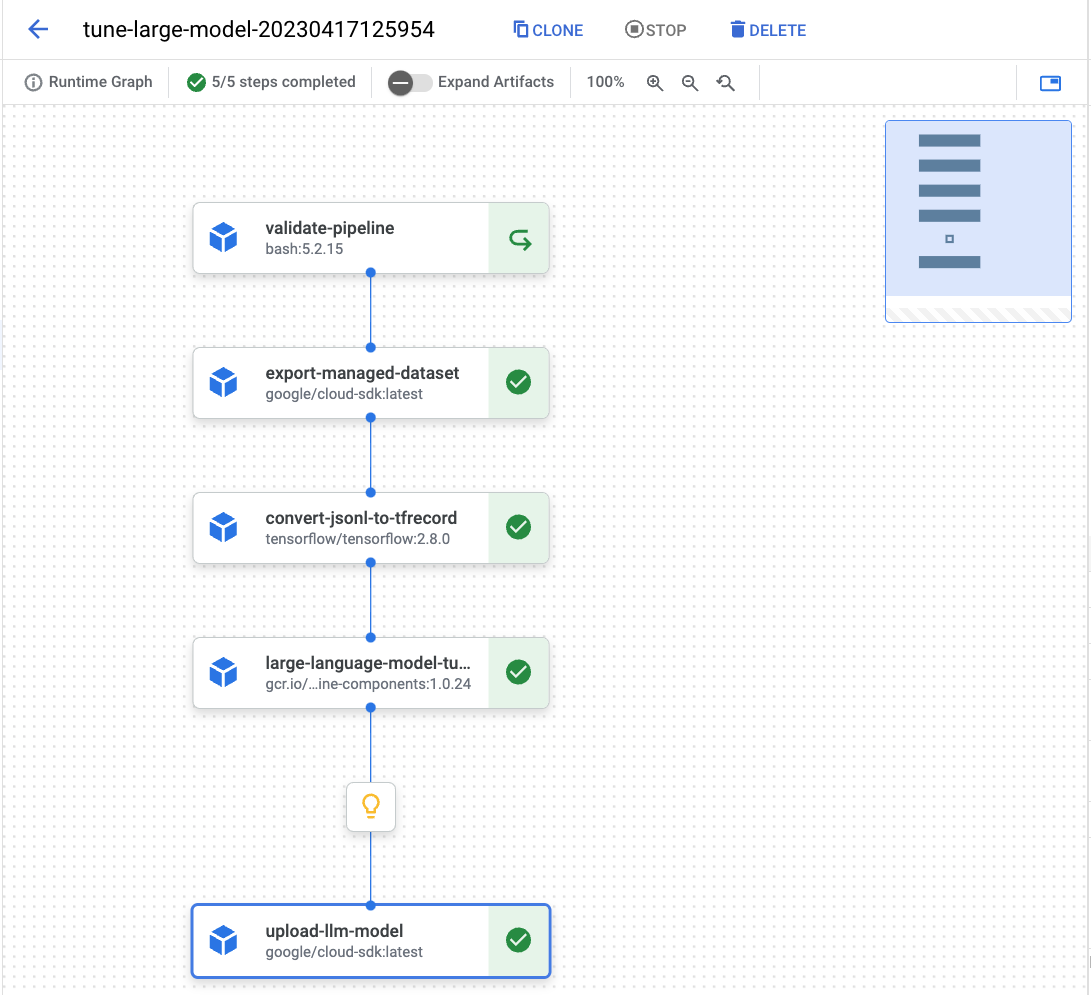

## View your tuned foundational model on Vertex AI Model registry
When your tuning job is finished, your model will be available on Vertex AI Model Registry. The following Python SDK sample shows you how to list tuned models.

In [ ]:
def list_tuned_models(project_id, location):

    aiplatform.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained("text-bison@001")
    tuned_model_names = model.list_tuned_model_names()
    print(tuned_model_names)

In [ ]:
list_tuned_models(PROJECT_ID, REGION)

You can also use the Google Cloud Console UI to view all of your model in [Vertex AI Model Registry](https://console.cloud.google.com/vertex-ai/models?e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=cloud-llm-preview1). Below you can see an example of a tuned foundational model available on Vertex AI Model Registry. 

## Use your tuned model to get predictions 
Now it's time to get predictions. First you need to get the latest tuned model from the Vertex AI Model registry.

In [ ]:
def fetch_model(project_id, location):

    aiplatform.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained("text-bison@001")
    list_tuned_models = model.list_tuned_model_names()
    tuned_model = list_tuned_models[0]

    return tuned_model

In [ ]:
deployed_model = fetch_model(PROJECT_ID, REGION)
deployed_model = TextGenerationModel.get_tuned_model(deployed_model)

Now you can start send a prompt to the API. Feel free to update the following prompt. 

In [ ]:
PROMPT = """
How can I save my TensorFlow model on Google Cloud Storage. Can you show me a Python example?

example: 

"""

In [ ]:
print(deployed_model.predict(PROMPT))